In [20]:
from time import time
import copy
import math

import torch
import torch_geometric
import GNNTrackingTools as GTT

from torch import optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.utils.data import random_split

from torch_geometric.data import Data, DataLoader, InMemoryDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

In [21]:
# Read data file
df = pd.read_pickle("/Users/mghrear/data/LDMX_GNN/test_8gev_electrons_withTracking_30000_MG_5e.pkl")

df.head()

,x,y,z,E,ID,Digi_x,Digi_y,Digi_z,Digi_E,Digi_ID
0,"[-6.1657863, -6.2280884, -7.4651546, -7.560230...","[-26.481228, -26.48133, -26.482199, -26.48193,...","[-615.5, -609.5, -515.5, -509.5, -415.5, -409....","[0.15620436, 0.09997243, 0.09009961, 0.0926791...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, ...","[-615.5, -615.5, -615.5, -615.5, -615.5, -609....","[1.942004, -4.2444515, -6.6921215, -2.1466496,...","[36.903976, 6.743964, 9.547099, 39.559414, -26...","[0.12266732, 0.08207677, 0.09806152, 0.0929563...","[1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, ..."
1,"[5.8142776, 5.7514205, 4.5055604, 4.5030046, 4...","[-4.253759, -4.2534556, -4.236259, -4.2362294,...","[-615.5, -609.5, -515.5791, -515.4191, -509.5,...","[0.07235471, 0.10053486, 0.058452714, 0.059001...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[-615.5, -615.5, -615.5, -615.5, -609.5, -609....","[-4.839602, 3.0073886, -5.221901, 5.824609, -4...","[-27.322662, -23.766891, 26.10426, -4.253757, ...","[0.09350429, 0.096878454, 0.1438558, 0.0723547...","[1, 2, 4, 5, 1, 2, 4, 5, 1, 2, 3, 4, 5, 1, 2, ..."
2,"[4.213131, 4.150041, 2.8889322, 2.7915063, 1.0...","[8.289397, 8.288871, 8.295825, 8.296521, 8.311...","[-615.5, -609.5, -515.5, -509.5, -415.5, -409....","[0.07305303, 0.17275162, 0.11246147, 0.0963572...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, ...","[-615.5, -615.5, -615.5, -615.5, -615.5, -609....","[5.7180843, 4.361154, 6.098156, 5.341816, 4.20...","[10.532579, 36.32064, -5.2584414, -24.705404, ...","[0.09474933, 0.09941378, 0.09285116, 0.1370235...","[1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, ..."
3,"[-8.000728, -8.063659, -9.310697, -9.40709, -1...","[-3.1684225, -3.1680837, -3.1666994, -3.166406...","[-615.5, -609.5, -515.5, -509.5, -415.5, -409....","[0.117367506, 0.11546926, 0.08352268, 0.133953...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, ...","[-615.5, -615.5, -615.5, -615.5, -609.5, -609....","[-6.8064766, 6.3133793, 5.9136863, -7.9964857,...","[-6.545982, -9.411359, -32.969704, -3.1684217,...","[0.11394499, 0.08193731, 0.11419299, 0.1173675...","[1, 2, 4, 5, 1, 2, 5, 1, 2, 3, 4, 5, 1, 2, 3, ..."
4,"[-0.31027097, -0.37312007, -1.6195923, -1.7161...","[-38.296078, -38.296215, -38.2967, -38.29707, ...","[-615.5, -609.5, -515.5, -509.5, -415.5, -409....","[0.1169872, 0.085270055, 0.09562814, 0.5204493...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, ...","[-615.5, -615.5, -615.5, -615.5, -615.5, -609....","[-5.952578, -6.0068917, -10.583366, -5.306094,...","[-32.221752, -22.433867, -14.395233, -34.41126...","[0.09708474, 0.103494875, 0.097312994, 0.15282...","[1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, ..."


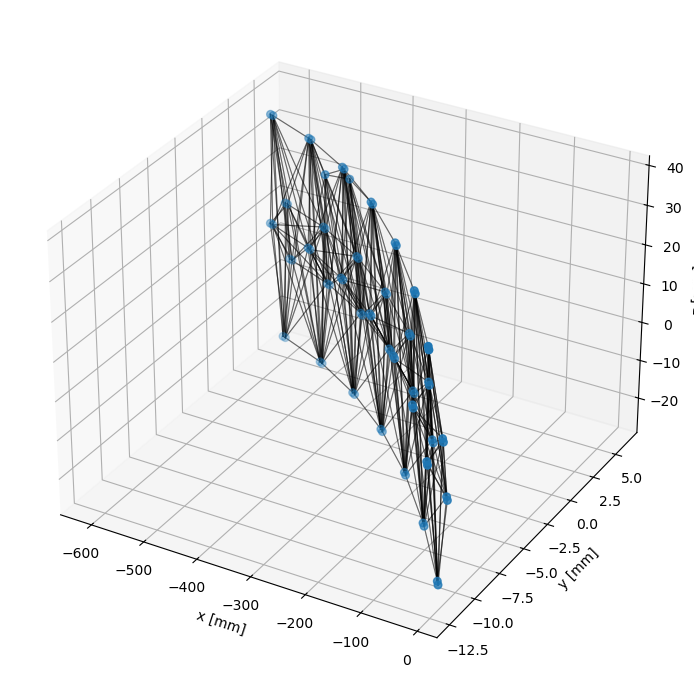

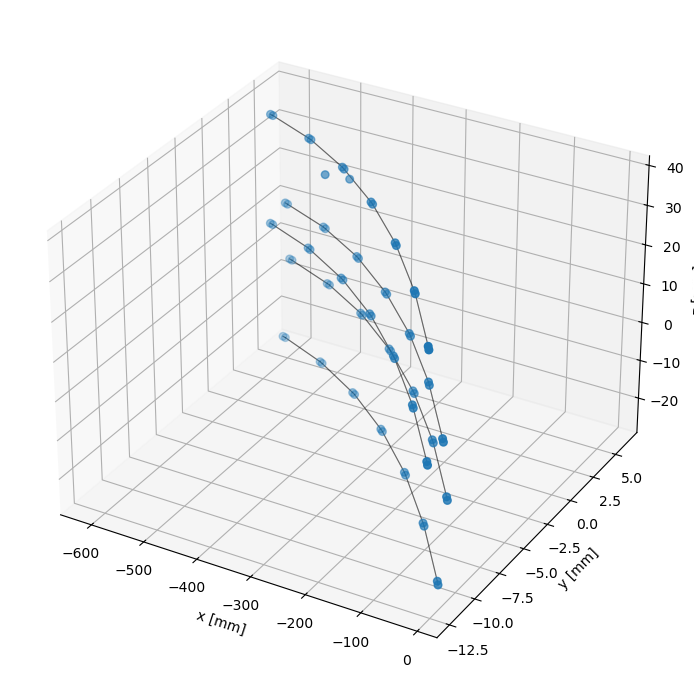

In [22]:
# Make GNN dataset
dataset = GTT.MyInMemoryDataset(df, n_primaries = 5, mode = "EC")

# Plot example graph
data = dataset[2]
GTT.plot_pyg_graph_3d(data, plot_truth=True)

In [7]:
# Split into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(42) )

# Make DataLoaders
batch_size = 30
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/var/folders/fx/czrkltw953xcpcjd85tf2tmm0000gn/T/ipykernel_34496/2210891527.py:6: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
/var/folders/fx/czrkltw953xcpcjd85tf2tmm0000gn/T/ipykernel_34496/2210891527.py:7: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
/var/folders/fx/czrkltw953xcpcjd85tf2tmm0000gn/T/ipykernel_34496/2210891527.py:8: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [9]:
# Initialize model
hidden_size = 40


model = GTT.MyIN(hidden_size).to(device)
total_trainable_params = sum(p.numel() for p in model.parameters())
print(f"Total trainable parameters: {total_trainable_params}")

Total trainable parameters: 10493


In [10]:
# Initialize optimizer

lr = 5E-3
step_size = 5
gamma = 0.9

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

# Training Loop

In [11]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    epoch_t0 = time()
    losses = []
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.edge_attr)
        y, output = data.y, output.squeeze(1)
        loss = F.binary_cross_entropy(output, y, reduction='mean')
        loss.backward()
        optimizer.step()
        # if batch_idx % 10 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx, len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()))
        losses.append(loss.item())
    print("...epoch time: {0}s".format(time()-epoch_t0))
    print("...epoch {}: train loss={}".format(epoch, np.mean(losses)))
    return np.mean(losses)

def validate(model, device, val_loader):
    model.eval()
    opt_thlds, accs, losses = [], [], []
    for batch_idx, data in enumerate(val_loader):
        data = data.to(device)
        output = model(data.x, data.edge_index, data.edge_attr)
        y, output = data.y, output.squeeze()
        loss = F.binary_cross_entropy(output, y, reduction='mean').item()
        losses.append(loss)
        
        # define optimal threshold (thld) where TPR = TNR 
        diff, opt_thld, opt_acc = 100, 0, 0
        best_tpr, best_tnr = 0, 0
        for thld in np.arange(0.001, 0.5, 0.001):
            TP = torch.sum((y==1) & (output>thld)).item()
            TN = torch.sum((y==0) & (output<thld)).item()
            FP = torch.sum((y==0) & (output>thld)).item()
            FN = torch.sum((y==1) & (output<thld)).item()
            acc = (TP+TN)/(TP+TN+FP+FN)
            TPR, TNR = TP/(TP+FN), TN/(TN+FP)
            delta = abs(TPR-TNR)
            if (delta < diff): 
                diff, opt_thld, opt_acc = delta, thld, acc

        opt_thlds.append(opt_thld)
        accs.append(opt_acc)

    print("...val accuracy=", np.mean(accs))
    print("...val loss=", np.mean(losses))
    return np.mean(opt_thlds), np.mean(losses) 

def test(model, device, test_loader, thld=0.5):
    model.eval()
    losses, accs = [], []
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            data = data.to(device)
            output = model(data.x, data.edge_index, data.edge_attr)
            TP = torch.sum((data.y==1).squeeze() & 
                           (output>thld).squeeze()).item()
            TN = torch.sum((data.y==0).squeeze() & 
                           (output<thld).squeeze()).item()
            FP = torch.sum((data.y==0).squeeze() & 
                           (output>thld).squeeze()).item()
            FN = torch.sum((data.y==1).squeeze() & 
                           (output<thld).squeeze()).item()            
            acc = (TP+TN)/(TP+TN+FP+FN)
            loss = F.binary_cross_entropy(output.squeeze(1), data.y, 
                                          reduction='mean').item()
            accs.append(acc)
            losses.append(loss)
            #print(f"acc={TP+TN}/{TP+TN+FP+FN}={acc}")

    print('...test loss: {:.4f}\n...test accuracy: {:.4f}'
          .format(np.mean(losses), np.mean(accs)))
    return np.mean(losses), np.mean(accs)

In [12]:
epochs = 20

best_val_loss = math.inf
best_thld = None
best_state_dict = None  # or best_model = None

output = {'train_loss': [], 'val_loss': [], 'test_loss': [], 'test_acc': [], 'optimal_thld': []}

for epoch in range(1, epochs + 1):
    print(f"---- Epoch {epoch} ----")
    train_loss = train(model, device, train_loader, optimizer, epoch)
    thld, val_loss = validate(model, device, val_loader)
    print('...optimal threshold', thld)

    # keep best model (lowest val loss) + its threshold
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_thld = thld
        best_state_dict = copy.deepcopy(model.state_dict())  # safest/common

    test_loss, test_acc = test(model, device, test_loader, thld=thld)
    scheduler.step()

    output['train_loss'].append(train_loss)
    output['val_loss'].append(val_loss)
    output['test_loss'].append(test_loss)
    output['test_acc'].append(test_acc)
    output['optimal_thld'].append(thld)

# later, restore best model + use best_thld
model.load_state_dict(best_state_dict)
thld = best_thld
    


---- Epoch 1 ----
...epoch time: 16.69485902786255s
...epoch 1: train loss=0.07353318688526217
...val accuracy= 0.9880688135162415
...val loss= 0.035282596349716186
...optimal threshold 0.4848133333333334
...test loss: 0.0353
...test accuracy: 0.9882
---- Epoch 2 ----
...epoch time: 16.991384029388428s
...epoch 2: train loss=0.020220847362985035
...val accuracy= 0.998313485279589
...val loss= 0.006507450056572755
...optimal threshold 0.3348133333333333
...test loss: 0.0062
...test accuracy: 0.9983
---- Epoch 3 ----
...epoch time: 17.504516124725342s
...epoch 3: train loss=0.015822827707410655
...val accuracy= 0.9984167129701496
...val loss= 0.004964429125345002
...optimal threshold 0.3679333333333334
...test loss: 0.0045
...test accuracy: 0.9984
---- Epoch 4 ----
...epoch time: 17.51909828186035s
...epoch 4: train loss=0.005063226942854401
...val accuracy= 0.998502361753079
...val loss= 0.004839510487702986
...optimal threshold 0.4099866666666667
...test loss: 0.0043
...test accuracy: 

In [14]:
# convert output to pandas DataFrame and save as pickle
output_df = pd.DataFrame(output)
output_df.to_pickle("LDMX_IN_training_output.pkl")

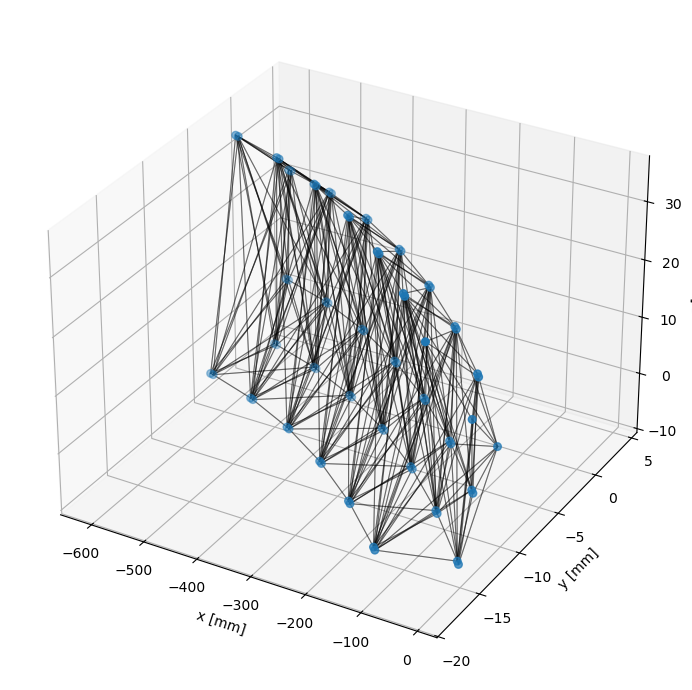

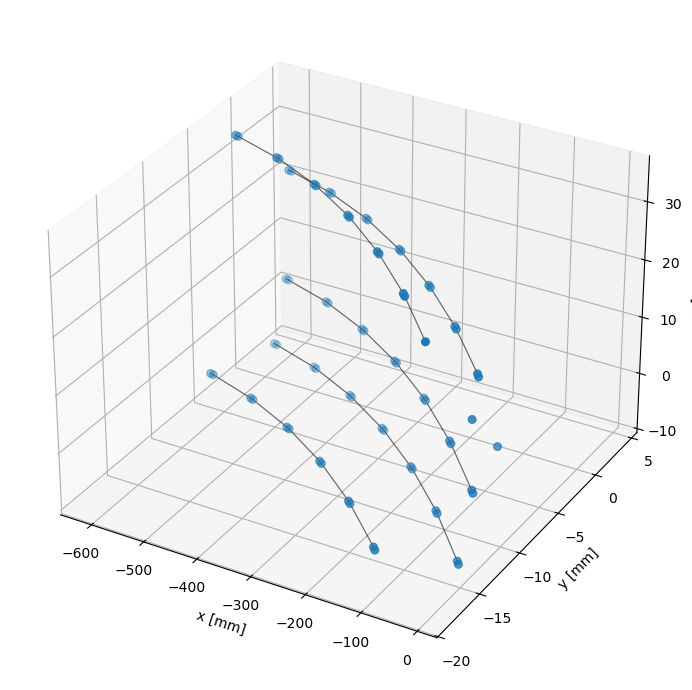

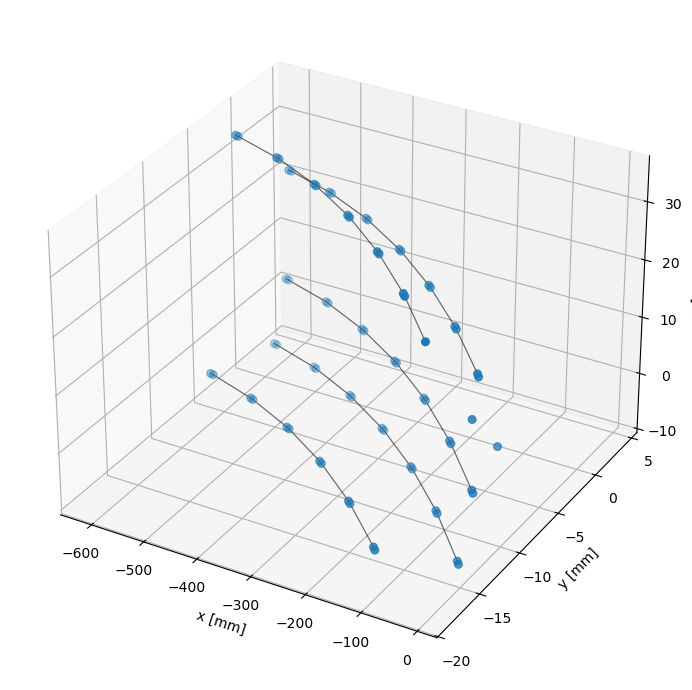

In [19]:
graph = test_dataset[2]
graph

# Analyze graph with model
model.eval()
data = graph.to(device)
output = model(data.x, data.edge_index, data.edge_attr).squeeze(1).detach().cpu()
graph.pred = output>thld


GTT.plot_pyg_graph_3d(data, plot_truth=True, plot_pred=True)

In [ ]:
graph 